# Products

## Describing Transactions

The descriptive information about each product is contained in `product.csv`. Let's look at what it would take to reference these product descriptions with `transaction_data.csv`.

**To effectively describe the purchase behaviour of households, we need to know what they bought**.


## Business Summary/tl;dr

1. The 3 **columns which describe the products are inadequate -- so I created my own 15 'bins' manually, by mapping the 308 labels in the 'COMMODITY_DESC' column**:
    'meat',
    'dairy',
    'produce',
    'grain_goods',
    'grocery',
    'beverages',
    'junk_food',
    'alcohol',
    'home_family',
    'kitchen',
    'garden',
    'drug',
    'seasonal',
    'concessions',
    'misc',


2. We located ~$600k worth of gasoline sales in the data. **Although gasoline sales make up \%8 of the revenue in the sales data, I've chosen to drop** those transactions from the analysis as we cannot change the price of gas; nor are we likely change its consumption, as a commodity.


3. With these data cleaning steps and new `Section Labels` for our `PRODUCT_ID`s, we've opened up the possibility for category-based sales analysis on the household level. 

**While not an effective data pipeline, manual binning is an answer that works for the real scope of this project**. We've developed this map as well as other functions to improve our data cleanliness, as part of an ELT process.

Other Notes:

- `meat` is the top-grossing category. `home_family` and `junk_food` make up the next two, with `produce` and `dairy` rounding out the top 5.


Notes February 2024:

Created 'create_section_labels' function in create_source_tables.py. Map still does not cover for new values -- 

# EDA for `product.csv`

In [3]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as datetime
plt.rcParams['figure.figsize'] = (12,8)

# import dtcj
from utilities import read_table, query

In [2]:
product = read_table('src_product')
product.head()

,product_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [3]:
# print unique values in each column (in lieu of histograms)
print('Number of Unique values in each column of product.csv')
print("*" * 40)

for col in product.columns:
    print(f'{product[col].nunique()}'.ljust(12), end='')
    print(f'{col}')
print()
print('*' * 40)
product.info()
print()
print(f'{product.shape} is the shape. Sum of nulls: {product.isna().sum().sum()}')


Number of Unique values in each column of product.csv
****************************************
92353       product_id
6476        manufacturer
44          department
2           brand
308         commodity_desc
2383        sub_commodity_desc
4345        curr_size_of_product

****************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92353 entries, 0 to 92352
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   product_id            92353 non-null  int64 
 1   manufacturer          92353 non-null  int64 
 2   department            92353 non-null  object
 3   brand                 92353 non-null  object
 4   commodity_desc        92353 non-null  object
 5   sub_commodity_desc    92353 non-null  object
 6   curr_size_of_product  92353 non-null  object
dtypes: int64(2), object(5)
memory usage: 4.9+ MB

(92353, 7) is the shape. Sum of nulls: 0


Despite having no nulls in the data, this table immediately does not appear to be 'clean'.

- There are empty strings in the last column, `CURR_SIZE_OF_PRODUCT`

- There are 'manufacturer' and 'brand' tags; 6476 manufacturers but just 2 'brand' labels.

- There are 3 columns we might use to describe the actual products; `DEPARTMENT, COMMODITY_DESC, and SUB_COMMODITY_DESC`

Data Dictionary for `product.csv`
---

`PRODUCT_ID`
- Unique Identifier

`MANUFACTURER`
- ~6500 distinct manufacturer labels

`DEPARTMENT`
- Most "coarse" level of product labelling; 44 department labels

`BRAND`
- Only 2 brands are listed --> National, and Private

`COMMODITY_DESC`
- Medium grade product level; 308 distinct commodity description labels

`SUB_COMMODITY_DESC`
- Finest level of product labelling; 2383 'sub-commodity description' labels

`CURR_SiZE_OF_PRODUCT`
- Despite no nulls in the columns, we noticed some empty fields in the head of the table.

## Initial Impressions

Despite having 4345 distinct values, `CURR_SIZE_OF_PRODUCT` has empty fields; we can see them at the top of the table.

Something that jumps out to me is that `BREAD:ITALIAN/FRENCH` with a `DEPARTMENT == PASTRY` label. That's not exactly precise.

**We'll have to take a closer look at how these products are being described in order to form a useful sales breakdown for any given household, store, or section of products**.

There's an argument to be made that this information is best examined in the context of which products our customers actually purchased. Let's bring in `transaction_data.csv` in order to see what we've got to begin with -- **this is not great for our data pipeline; we would need to perform an in-depth examination of all 93000 products** in order to be sure that each one was labelled correctly. 

However, we don't know for sure that we'll ever have more data, so let's press on for now. Speaking to the client about building effective data infrastructure is a separate discussion.

Product labels in the context of transactions
---


In [14]:
# load transaction_data.csv and form 'merged' by combining the tables on PRODUCT_ID
transactions = read_table('stg_transaction_data')
# include the section labels which were parsed in Summer 2021
prod = read_table('src_product').merge(read_table('section_labels'), how='left', on='commodity_desc')
merged = transactions.merge(prod, on='product_id')



# Examining Product Sales 

## by `DEPARTMENT`


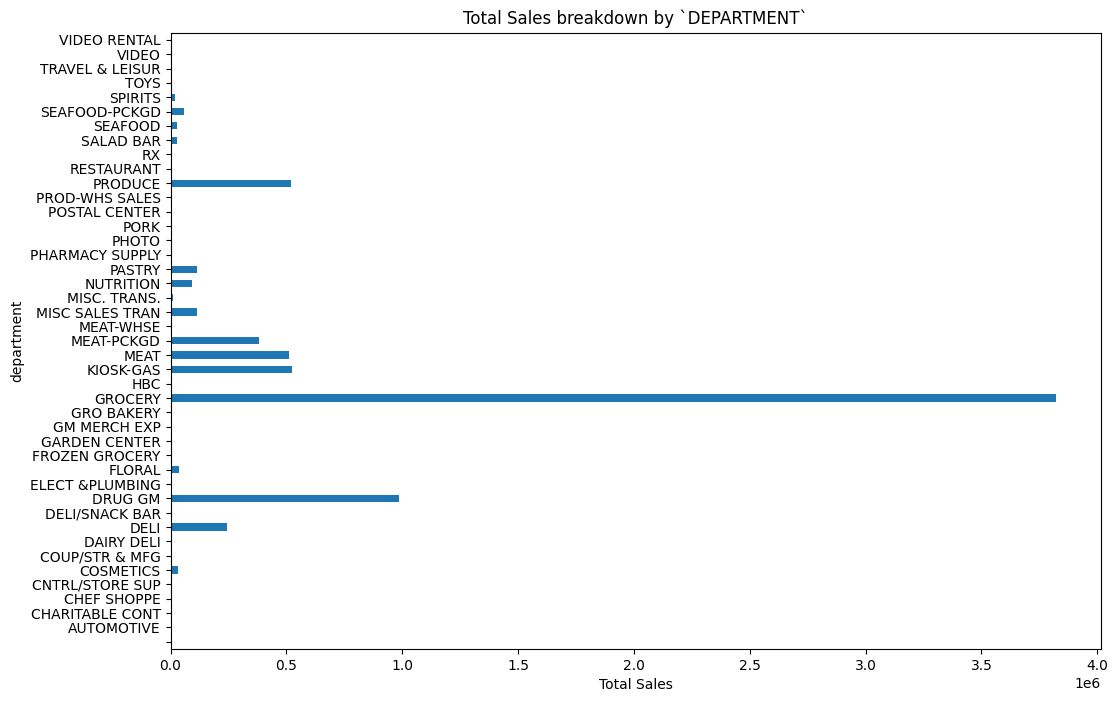

In [5]:
# look at sum of sales aggregate by DEPARTMENT label
merged.groupby('department')['sales_value'].sum().plot(kind='barh')
plt.title('Total Sales breakdown by `DEPARTMENT`')
plt.xlabel('Total Sales')
plt.show()

**These department labels don't look very good.** There are some categories with almost no sales at all; in other places we seem to have redundant labels (MISC. TRAN + MISC SALES TRAN). `GROCERY` is by far the largest category, comprising transactions worth \\$4 million -- half of our revenue. But why is `PRODUCE`, or `MEAT` not a part of the `GROCERY` section?

- 44 categories already makes interpretation difficult

Moreover, we're not getting a lot of value by using so many labels:

- For the purposes of unsupervised learning, (or plain binning!) we want our labels to distinguish items sales from one another. This would mean breaking apart the GROCERY section into more meaningful tags. 

Let's go to the next-most granular level. 

## By `COMMODITY DESC`

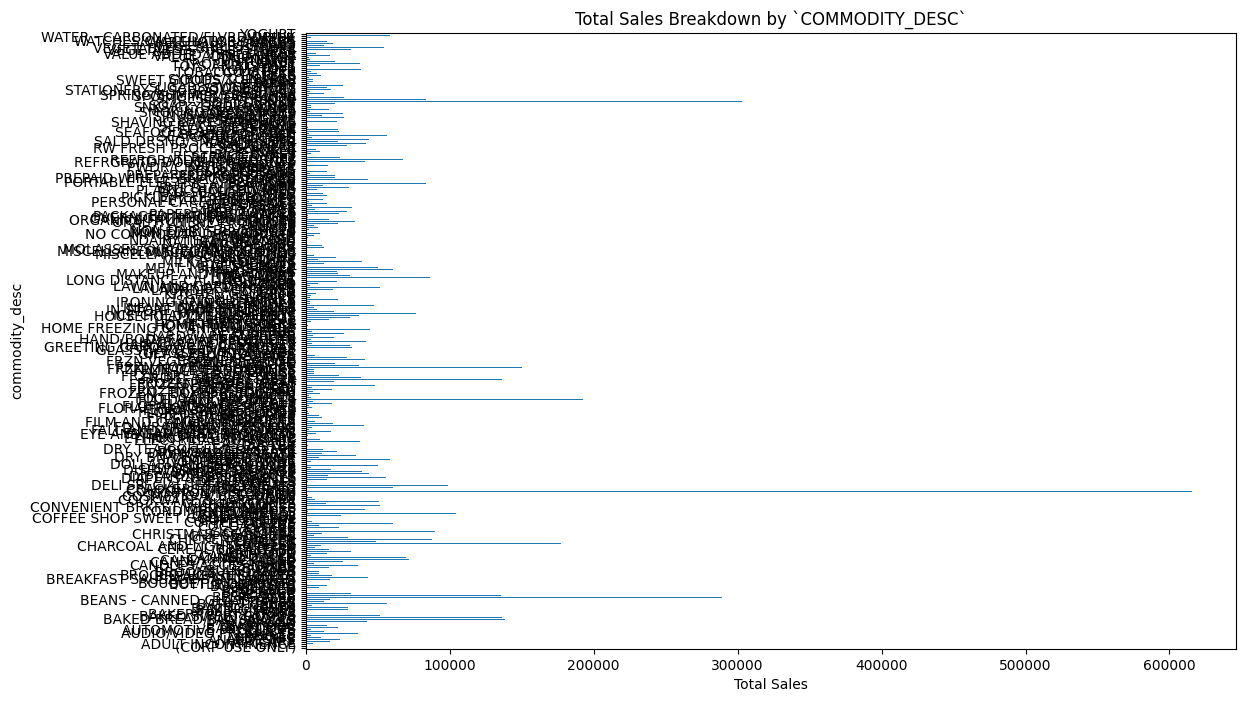

In [6]:
merged.groupby('commodity_desc')['sales_value'].sum().plot(kind='barh')
plt.title('Total Sales Breakdown by `COMMODITY_DESC`')
plt.xlabel('Total Sales')
plt.show()

**The graph above is incomprehensible** -- there are too many categories to plot in a clear way.

Let's look at the top-grossing categories from these labels:

### Top-grossing `COMMODITY_DESC` categories

In [7]:
merged.groupby('commodity_desc')['sales_value'].sum().sort_values(ascending=False).head(10)

commodity_desc
COUPON/MISC ITEMS         615301.97
SOFT DRINKS               302928.25
BEEF                      289110.07
FLUID MILK PRODUCTS       192563.06
CHEESE                    177503.20
FRZN MEAT/MEAT DINNERS    150368.17
BAG SNACKS                138061.23
FROZEN PIZZA              136596.85
BAKED BREAD/BUNS/ROLLS    136226.87
BEERS/ALES                135846.26
Name: sales_value, dtype: float64

There are 308 `COMMODITY_DESC` labels. We can visualize the most profitable sections:

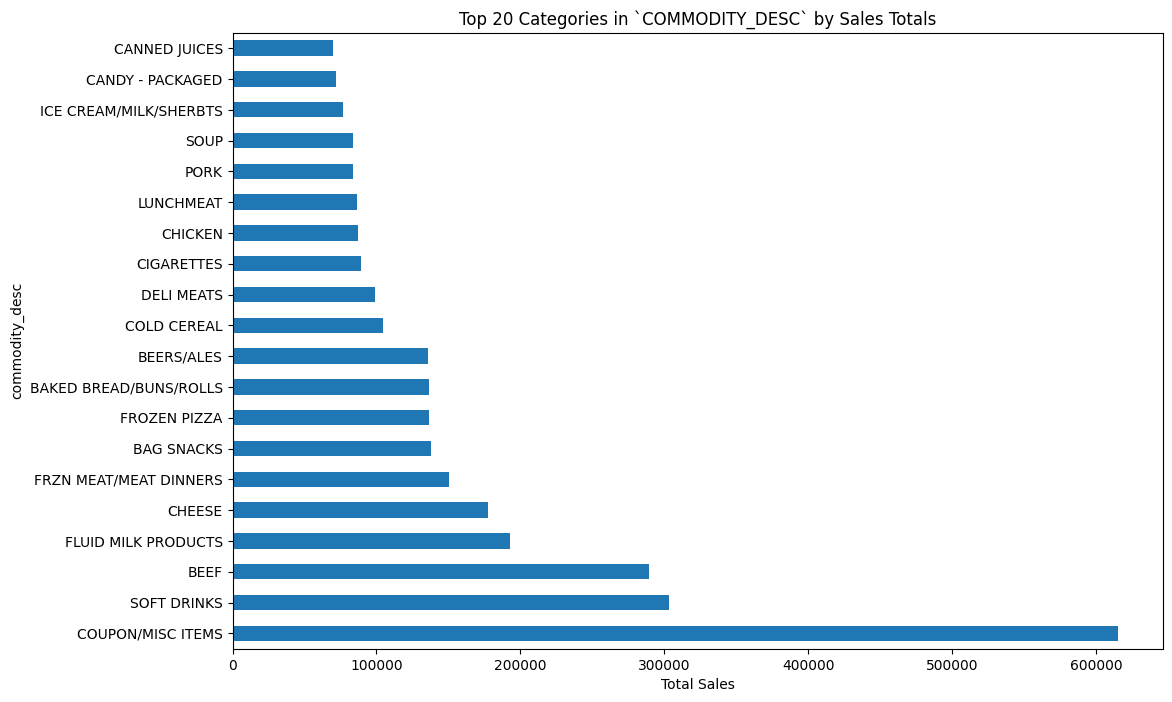

In [8]:
# plotting top 25 most valuable 'COMMODITY_DESC' categories
merged.groupby('commodity_desc')['sales_value'].sum().nlargest(20).plot(kind='barh')
plt.title('Top 20 Categories in `COMMODITY_DESC` by Sales Totals')
plt.xlabel('Total Sales')
plt.show()

- Again we can see **products which are similar being grouped in separate categories**. In terms of describing household purchase behaviour, my stance is that `CHICKEN` versus `PORK` might not be the best distinction to draw; but I would certainly yield to greater wisdom from a subject matter expert or more senior team member.

- Products from the `COUPON/MISC ITEMS` category are the top-grossing label; over \\$600000, almost double the next largest category (soft drinks!)

## Unpacking `COUPON/MISC ITEMS`

What kinds of products are in `COUPON/MISC ITEMS` that are making up such a high proportion of our total sales?

That's not a very descriptive category label. It's not great that this is our highest-grossing `COMMODITY_DESC` label; it further indicates that these labels were not put together with analysis in mind.

Taking only the transactions from `COUPON/MISC ITEMS`, lets move to the most granular descriptive column, `SUB_COMMODITY_DESC`. 

In [9]:
# top 5 `SUB_COMMODITY_DESC` sum of sales from merged[COMMODITY_DESC == 'COUPON/MISC ITEMS']

merged[merged['commodity_desc'] == 'COUPON/MISC ITEMS'].groupby('sub_commodity_desc')['sales_value'].sum().nlargest(10)

sub_commodity_desc
GASOLINE-REG UNLEADED             581519.47
ELECTRONIC GIFT CARDS ACTIVATI      8418.04
MEAT SUPPLIES                       4779.57
OUTSIDE VENDORS GIFT CARDS          4106.64
MISCELLANEOUS H & B AIDS            3289.19
MISC SALES TRANS                    3117.05
ELECTRONIC GIFT CARDS REFRESH       2651.40
MASTERCARD GIFT CARD                1763.13
PRODUCE DEPT KEY RING               1553.41
FLORAL DEPT KEY RING                 995.22
Name: sales_value, dtype: float64

In [10]:
(merged[merged['sub_commodity_desc']=='GASOLINE-REG UNLEADED']['sales_value'].sum()/merged['sales_value'].sum())*100

# gasoline represents more than 8% of the sales in our cleaned data -- a very significant total.

8.097943254559285

Bingo, it's **gasoline**. The gas transactions from `COMMODITY_DESC` == `GASOLINE-REG UNLEADED` make up \\$600 000 worth of sales.

How much of our total revenue is accounted for by gasoline?

That's a different number from what we had above; we grouped by SUB_COMMODITY_DESC only for the COMMODITY_DESC label. This is getting messy. Gas transactions seem to be spread over several commodity description labels.

These sales are not insignificant, with respect to our data -- they make up almost 8% of the revenue.

**We don't control the cost or sales value of gas; it's a commodity**. There could be purchase behaviours that are triggered by trips to the gas station, or we could look at gas sales for distinct `STORE_ID`s; however, we don't have geospatial data for our stores. I would suggest we drop these transactions from our analysis. 


### Dropping Gasoline Sales

In [11]:
# # dropping gas transactions from 'merged'
# merged.drop(merged[merged['SUB_COMMODITY_DESC'] == 'GASOLINE-REG UNLEADED'].index, inplace=True)
# merged.drop(merged[merged['COMMODITY_DESC'] == 'FUEL'].index, inplace=True)

## Top-Grossing products by  `SUB_COMMODITY_DESC` 

In [12]:
merged.groupby('sub_commodity_desc')['sales_value'].sum().nlargest(20)

sub_commodity_desc
GASOLINE-REG UNLEADED             610245.19
FLUID MILK WHITE ONLY             151629.58
SOFT DRINKS 12/18&15PK CAN CAR    145670.06
BEERALEMALT LIQUORS               137244.13
CIGARETTES                         89515.54
CHOICE BEEF                        73193.48
SHREDDED CHEESE                    63523.29
PRIMAL                             62304.95
PREMIUM                            60150.06
BABY DIAPERS                       55454.59
TOILET TISSUE                      54713.15
SFT DRNK 2 LITER BTL CARB INCL     49872.71
POTATO CHIPS                       49200.94
SNACKS/APPETIZERS                  46304.49
DAIRY CASE 100% PURE JUICE - O     44355.48
KIDS CEREAL                        43258.93
ENHANCED                           42267.57
LIQUID LAUNDRY DETERGENTS          41924.14
MAINSTREAM WHITE BREAD             41338.37
LEAN                               40672.49
Name: sales_value, dtype: float64

So we have cigarettes and beer/ale/malt liquors; as well as some labels which make no sense on their own (PRIMAL, ENHANCED, LEAN). 

# Summary of Product Labels EDA

We'd like to examine what sorts of products each household is purchasing more or less of, over time.

In order to do so, we need accurate product labels -- such that we can examine the changes in spending for different categories in a clear (and consistent) way.

- We noticed that the `GROCERY` label in the `DEPARTMENT` column represents a disproportionate amount of the sales value of our products. 
- `COMMODITY_DESC` is our best bet, but we noticed some overlapping labels -- and 308 categories is too many to plot.
- `SUB_COMMODITY_DESC` has good information for reference, but if we want to compare sales between sections, **we need fewer, but more accurate/descriptive labels in order to make visualizations clear**.

Just briefly, let's take a look at the most profitable `SUB_COMMODITY_DESC` products (likely the categories with the most consistently-labeled products)

## Plotting Product Sales

Let's take a look at what we've got...

### by `DEPARTMENT`

In [13]:


# messy plot! even after DROPPING `GROCERY` ...
# plt.subplots(figsize=(16,4))
# for dept in merged['department'].unique():
#     if dept != 'GROCERY':
#         merged[merged['department']==dept].groupby('WEEK_NO')['SALES_VALUE'].sum().plot(label=f'{dept}')
# plt.legend()

**We can't see anything in this visualization -- it's terrible**.

Even after dropping the `GROCERY` label for a closer look (the one for which we actually want definition)...

**The graph above does not give clarity**; everything is jumbled up together and many categories have sales approaching 0. Moreover, as we've noted before, the categories feel somewhat arbitrary -- they don't **effectively group similar products**.

We need broader brushstrokes; but distinct colours. Or at least, **fewer and more meaningful section labels**. Even 44 `DEPARTMENT` sections would be confusing to plot.

# Manual Binning

I considered leveraging NLP and unsupervised learning to cluster products based on a concatenation of the 3 descriptive column fields, but wanted more control -- already, I don't trust the labels in the data. I can't rely on a transfer-learning model to be able to interpret nonsensical tags. This might require a fine-toothed comb.


## Notes on Process 

I had a few confused moments when performing the binning, and it only took the `COMMODITY_DESC` column into account. There could be extra definition of the products in the ~2200 `SUB_COMMODITY_DESC` labels that I did not process at this stage. 

Instead, I started to 'pop()' the topmost categories off of the sum of sales list to group the many different `MEAT` labels together...which gave me an idea.

I decided to **manually separate the 308 `COMMODITY_DESC` labels into more meaningful categories** and then map that new column back onto the data.

In [14]:
def parse_list(ser, d):
    '''    
    Function to manually iterate through a Series `ser` (COMMODITY_DESC labels) and
    bin the results into the container  `d` with a manually-entered tag.
    
    ENTER 'exit', quit' or 'q' to exit!

    '''
    for idx, row in ser.iteritems():
        #prompt
        print(f'DEPARTMENT LABEL : "{idx}"')
        choice = input('What Category? ')
        # exiting
        if (choice.casefold() == 'quit') or (choice.casefold()=='q') or (choice.casefold()=='exit'):
            print('exiting')
            break
        else:
        # entering into dict or appending to section label
            if choice in d:
                d[choice].append(idx)
            else:
                d[choice] = [idx]

The example usage below won't mess anything up...

**AS LONG AS YOU EXIT THE FUNCTION**. 

Be sure to type 'quit', 'exit' or 'q' when you're done -- sorry for including it in a Jupyter notebook.

In [16]:
## example; type 'q', 'exit', or 'quit' to exit
commodity_sos = merged.groupby('commodity_desc')['sales_value'].sum()
new_dict = dict()
parse_list(commodity_sos, new_dict)
new_dict

AttributeError: 'Series' object has no attribute 'iteritems'

I opted to not look at the `DEPARTMENT` and `SUB_COMMODITY_DESC` labels at the same time; I need a map for the **unique values of `COMMODITY_DESC`**. 

It's not very well abstracted, and doesn't have all the functionality I might like to see...but the baby works.

This sort of manual binning doesn't necessarily fit into a date pipeline very well; **the map doesn't account for new `COMMODITY_DESC` labels beyond the ones we have in this table**. As mentioned above, the `DEPARTMENT` labels are basically useless; and the SUB_COMMODITY_DESC labels would take just a little too long (although by now, I could have finished them for sure...). 

`COMMODITY_DESC` offers sufficient information to classify or label a product, without confusing things too much.

In my experience, **it is sometimes necessary when dealing with an imperfect situation to have an imperfect solution** which serves your needs.

I saved the resulting dictionary to a text file, and have included it in the repo. 


The following product groups are available in the map:

In [ ]:
with open('Section_Labels.txt', 'r') as f:
    d = eval(f.read())
    
reversed_map = dict((v, k) for k, v in d.items()) ### JUST FOR PRINTING!
reversed_map.keys()


dict_keys(['meat', 'dairy', 'junk_food', 'produce', 'alcohol', 'beverages', 'home_family', 'grain_goods', 'misc', 'drug', 'grocery', 'kitchen', 'seasonal', 'concessions', 'garden'])

In [ ]:
len(merged['COMMODITY_DESC'].unique())

307

In [ ]:
len(d)

307

## Mapping new Section Labels

In [22]:
# read_table('section_labels').T.to_dict()

In [45]:
merged = merged.merge(read_table('section_labels'), how='left', on='commodity_desc')

In [47]:
merged[merged['section_label'].isna()]

,datetime,basket_id,product_id,quantity,sales_value,retail_disc,coupon_disc,coupon_match_disc,store_id,household_key,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,section_label
4036,2004-07-02 11:03:00,28197821585,6533765,1,12.00,0.0,0.0,0.0,343,1397,69,KIOSK-GAS,Private,FUEL,GASOLINE-REG UNLEADED,,NaN
5776,2004-07-03 22:47:00,28210580587,6533765,1,10.00,0.0,0.0,0.0,361,232,69,KIOSK-GAS,Private,FUEL,GASOLINE-REG UNLEADED,,NaN
17459,2004-07-05 12:51:00,28243591353,6533765,1,10.00,0.0,0.0,0.0,361,232,69,KIOSK-GAS,Private,FUEL,GASOLINE-REG UNLEADED,,NaN
23279,2004-07-06 16:10:00,28258028596,6533765,1,4.00,0.0,0.0,0.0,343,1550,69,KIOSK-GAS,Private,FUEL,GASOLINE-REG UNLEADED,,NaN
23349,2004-07-06 22:21:00,28258031777,6533765,1,2.74,0.0,0.0,0.0,343,2492,69,KIOSK-GAS,Private,FUEL,GASOLINE-REG UNLEADED,,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2420088,2006-02-28 10:51:00,42250600606,6533765,1,4.08,0.0,0.0,0.0,388,534,69,KIOSK-GAS,Private,FUEL,GASOLINE-REG UNLEADED,,NaN
2422000,2006-02-28 11:19:00,42250930809,6533765,1,20.00,0.0,0.0,0.0,318,2400,69,KIOSK-GAS,Private,FUEL,GASOLINE-REG UNLEADED,,NaN
2422002,2006-02-28 16:05:00,42250932277,6533765,1,18.00,0.0,0.0,0.0,318,275,69,KIOSK-GAS,Private,FUEL,GASOLINE-REG UNLEADED,,NaN
2422004,2006-02-28 17:34:00,42250932920,6533765,1,15.00,0.0,0.0,0.0,318,33,69,KIOSK-GAS,Private,FUEL,GASOLINE-REG UNLEADED,,NaN


In [ ]:
merged['Section Labels'] = merged['COMMODITY_DESC'].map(d)

merged['Section Labels']

0          produce
1          produce
2          produce
3          produce
4          produce
            ...   
2595727       misc
2595728    alcohol
2595729    alcohol
2595730    alcohol
2595731    alcohol
Name: Section Labels, Length: 2570770, dtype: object

# Sales Analysis by `Section Labels`

Now that we have product labels, what can we say about purchases across categories over the course of the data?

In [ ]:
# merged = dtcj.load_merged()

In [ ]:
from utilities import datetime_to_date

datetime_to_date(merged)
# merged['date']

In [ ]:
test

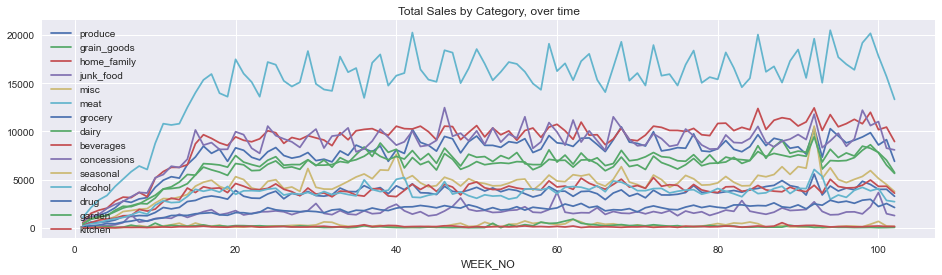

In [ ]:
# less messy plot
plt.subplots(figsize=(16,4))
plt.title(f'Total Sales by Category, over time')
for dept in merged['Section Labels'].unique():
    merged[merged['Section Labels']==dept].groupby('WEEK_NO')['SALES_VALUE'].sum().plot(label=f'{dept}')
plt.legend(loc='upper left')
plt.show()

In [ ]:
merged.groupby('Section Labels')['SALES_VALUE'].sum().nlargest()

Section Labels
meat           1532390.31
home_family     933754.93
junk_food       874321.95
produce         788331.19
dairy           670525.70
Name: SALES_VALUE, dtype: float64

## Observations of the plot

`meat` is the most profitable category overall. `home_family` (which is something of a mixed bag) and `junk_food` make up the next two, with `produce` and `dairy` rounding out the top 5.

We can see the **'leading tail' to our sales data**. Things seem to level off by around week 20 -- but we don't have context for this inconsistency. It's most likely a 'problem' in data acquisition, but for all we know this is the first sales data for the company and they're just starting to open stores.

One thing that *does* stand out about the plot is the occurrence (or concurrence) of **spikes in sales across various categories**. I wonder if these jumps in sales are seasonal; anomalous; or pertain to a particular advertising campaign? 

## Top-Grossing by Category

Which `COMMODITY_DESC` labels were most frequently purchased, in each Section?

In [ ]:
def print_top_sellers(df, 
                      label='Section Labels', 
                      counts='COMMODITY_DESC',
                     howmany=5):
    readout = dict()
    for section in df[label].unique():
        readout[section] = df[df[label]==section][counts].value_counts()
        print(f'********{section}*********')
        print(readout[section].head(howmany))
        
#     return readout

print_top_sellers(merged)

********produce*********
VEGETABLES - SHELF STABLE    41612
TROPICAL FRUIT               34442
FRZN VEGETABLE/VEG DSH       22564
FRUIT - SHELF STABLE         21536
DRY BN/VEG/POTATO/RICE       21213
Name: COMMODITY_DESC, dtype: int64
********grain_goods*********
BAKED BREAD/BUNS/ROLLS      83232
COLD CEREAL                 37870
CRACKERS/MISC BKD FD        29723
REFRGRATD DOUGH PRODUCTS    18960
DRY NOODLES/PASTA           17331
Name: COMMODITY_DESC, dtype: int64
********home_family*********
BABY FOODS               20356
CAT FOOD                 16210
FD WRAPS/BAGS/TRSH BG    14145
BATH TISSUES             14051
HAIR CARE PRODUCTS       12157
Name: COMMODITY_DESC, dtype: int64
********junk_food*********
SOFT DRINKS          117532
BAG SNACKS            67190
FROZEN PIZZA          43362
CANDY - CHECKLANE     35556
CANDY - PACKAGED      34177
Name: COMMODITY_DESC, dtype: int64
********misc*********
CONDIMENTS/SAUCES                 23514
CONVENIENT BRKFST/WHLSM SNACKS    22547
SALD DRS

In [ ]:
# observations:
# since parsing was done on each unique "commodity_desc" value and not on combinations of "department", "commodity" and "sub_commodity_desc"; 

merged.groupby('commodity_desc')['section_label'].nunique().value_counts() # length 1-2 # gasoline sales were not truncated in this iteration
merged.groupby('sub_commodity_desc')['section_label'].nunique().value_counts() # length 1-9 # since parsing of each sub
merged.groupby('sub_commodity_desc')['commodity_desc'].nunique().value_counts()# length 1-20 # some sub_commodity_desc have multiple commodity descriptions!?
merged.groupby('section_label')['department'].unique().apply(len)# section labels cross multiple departments
merged.groupby('sub_commodity_desc')['department'].unique().apply(len).value_counts() # same sub_commodity exists in up to 5 departments; one exists in 9

department
1    1935
2     366
3      52
4       8
9       1
5       1
Name: count, dtype: int64

In [ ]:
def create_product_stage():
    prod = read_table('src_product').merge(read_table('section_labels'), how='left', on='commodity_desc')
    con = sqlite3.connect('dunnhumby.db')
    with con:
        con.execute('CREATE TABLE stg_product ())


def create_merged()
# merged = read_table('stg_transaction_data').merge(read_table('src_product'), on='product_id')


As we can see above, these labels are not perfect. The distributions are bad; and could probably use a second pass through... I'd like to stand up the structure from start to finish, such that I can modify it in an abstract way. This is currently a WIP.

---